# Count Pedestrians with CNN

From the street views collected from 114 NYC locations, we are going to detect pedestrians using CNN. 
Here we are going to use Google's Tensorflow Object Detection API(TODA). This will give you identified person in the picture and its probability. 

### install TODA
Install TODA under project_root/src/models by running this at project_root/src

```
git clone git@github.com:tensorflow/models.git
```
Then follow steps in the instruction below:

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

### get pre-trained network
Create models directory under project_root and download faster_rcnn_resnet101_coco network and unzip.
```
mkdir ../models
wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz -P ../models
gunzip -c ../models/faster_rcnn_resnet101_coco_11_06_2017.tar.gz | tar x -C ../models
```

* If you installed GODA or pretraned network in a different location, edit project_root/src/core.py accordingly.

## Import packages

In [1]:
import sys
import warnings
import os

from PIL import Image
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

sys.path.append("../src")
from core import detect

warnings.filterwarnings('ignore')
%matplotlib inline

/home/ubuntu/anaconda3/envs/nyc_ped_count_cnn/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/nyc_ped_count_cnn/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/nyc_ped_count_cnn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/nyc_ped_count_cnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_convert

## Detect with Tensorflow object detection API

In [2]:
image_dir = '../data/raw/streetview-nyc'
out_dir = '../data/processed/streetview-nyc'
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

In [3]:
%%time
result = detect(image_dir, 
                min_score_thresh=0.01, 
                draw_box=True, 
                out_dir=out_dir)

CPU times: user 21min 23s, sys: 1min 6s, total: 22min 29s
Wall time: 26min 37s


## Check results

In [4]:
result.head()

,image,lid,score
0,LOC_27_h140.jpg,27,0.957003
1,LOC_27_h140.jpg,27,0.946221
2,LOC_27_h140.jpg,27,0.445668
3,LOC_27_h140.jpg,27,0.231392
4,LOC_27_h140.jpg,27,0.179378


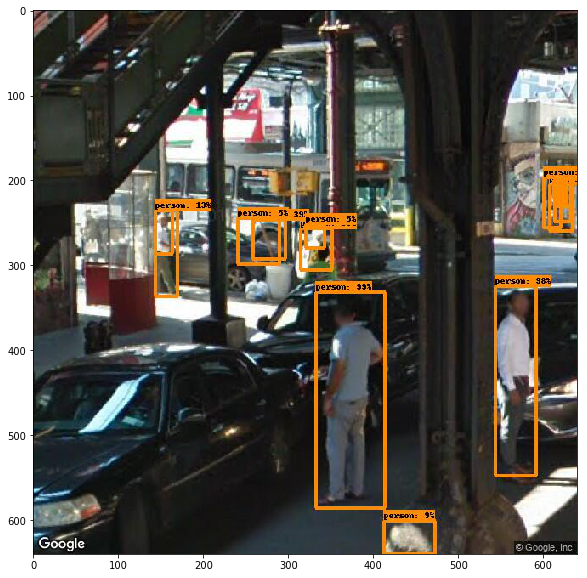

In [10]:
img_path = os.path.join(out_dir, "LOC_0_h180_anno.jpeg")
plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread(img_path))

In [5]:
result.to_csv("../data/dataframe/nyc-cnn-exp.csv")

In [12]:
# group by lid
result.groupby('lid').agg('sum')

,score
lid,
0,63.897798
1,21.141662
10,42.638332
100,26.366784
101,4.395309
102,1.000502
103,8.527547
104,1.096654
105,6.750283
